# Boundary Equilibrimum infoGANs for Fault Detection example

## 초기 설정들

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="0"


import pickle
import gzip

file_dir = 'anoGANs_MNIST_data/'

with gzip.open(file_dir + 'test_normal_data_inc_9.pickle.gzip','rb') as f :
    test_normal_data = pickle.load(f)
    print('test_normal_data : ' ,test_normal_data.shape)

with gzip.open(file_dir + 'test_anomalous_data_inc_9.pickle.gzip','rb') as f :
    test_anomalous_data = pickle.load(f)
    print('test_anomalous_data : ',test_anomalous_data.shape)
    
with gzip.open(file_dir + 'train_normal_data_inc_9.pickle.gzip','rb') as f :
    train_normal_data = pickle.load(f)
    print('train_normal_data : ', train_normal_data.shape)
    
with gzip.open(file_dir + 'train_anomalous_data_inc_9.pickle.gzip','rb') as f :
    train_anomalous_data = pickle.load(f)
    print('train_anomalous_data : ',train_anomalous_data.shape )

def idx_shuffle(x) : 
    l = x.shape[0]
    idx = np.arange(l)
    np.random.shuffle(idx)
    shuffled_x = np.empty(x.shape)

    for i in range(l):
        shuffled_x[idx[i]] = x[i]
    
    return shuffled_x

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(64, 64), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None

file_name = 'test2_BE_infoGANs_for_bench_marking_case_1'
#file_name = 'test2_BE_infoGANs_for_'


test_normal_data :  (8991, 64, 64, 1)
test_anomalous_data :  (1009, 64, 64, 1)
train_normal_data :  (49546, 64, 64, 1)
train_anomalous_data :  (5454, 64, 64, 1)


## network load

In [2]:
if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
c = sess.graph.get_tensor_by_name("c:0")
u = sess.graph.get_tensor_by_name("u:0")
k = sess.graph.get_tensor_by_name("k:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

G_sample = sess.graph.get_tensor_by_name("G_sample:0")
E_z = sess.graph.get_tensor_by_name("E_z:0")
E_c = sess.graph.get_tensor_by_name("Reshape:0")



re_image = sess.graph.get_tensor_by_name("re_image:0")
re_z = sess.graph.get_tensor_by_name("re_z:0")
re_c = sess.graph.get_tensor_by_name("Reshape_1:0")

re_z_loss = sess.graph.get_tensor_by_name("re_z_loss:0")
re_c_loss = sess.graph.get_tensor_by_name("re_c_loss:0")
re_image_loss = sess.graph.get_tensor_by_name("re_image_loss:0")


E_loss = sess.graph.get_tensor_by_name("E_loss:0")

D_real = sess.graph.get_tensor_by_name('D_real:0')                       # D(x)
D_fake = sess.graph.get_tensor_by_name('D_fake:0')         # D(G(z))
Q_fake = sess.graph.get_tensor_by_name("Q_fake:0")


D_enc = sess.graph.get_tensor_by_name("D_enc_1:0")

D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
Q_loss  = sess.graph.get_tensor_by_name("Q_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")
E_optim = sess.graph.get_operation_by_name("E_optim")
E_AE_optim = sess.graph.get_operation_by_name("E_AE_optim")




INFO:tensorflow:Restoring parameters from test2_BE_infoGANs_for_bench_marking_case_1/para.cktp


In [3]:
train_epoch = 15
batch_size = 100
z_size = 100
lam = 0.001
gamma = 0.5
k_curr = 0.0
c_size = 10


file_name1 = 'test2_BE_infoGANs_for_bench_marking_case_1'


if not os.path.isdir(file_name1) :
    os.mkdir(file_name1)

In [ ]:
np.random.seed(int(time.time()))


one_hot = np.eye(c_size)
temp2 = np.array([1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4])
test_c = one_hot[temp2].reshape([-1,1,1,c_size])
test_z = np.random.uniform(-1,1,size=(16,1,1,z_size))
mnist_4by4_save(np.reshape(test_normal_data[0:16],(-1,64,64,1)),file_name1 + '/normal.png')    
mnist_4by4_save(np.reshape(test_anomalous_data[0:16],(-1,64,64,1)),file_name1 + '/anomalous.png')    

E_error = []
start = time.time()
for epoch in range(train_epoch) :

    np.random.seed(int(time.time()))
    train_normal_data = idx_shuffle(train_normal_data) 

    for iteration in range(train_normal_data.shape[0] // batch_size) : 


        train_images = train_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
        u_ = np.reshape(train_images,(-1,64,64,1)) 
        z_ = np.random.uniform(-1,1,size=(batch_size,1,1,z_size))
        temp1 = np.random.randint(0,10,(batch_size))                                                                                                                                     
        c_ = one_hot[temp1].reshape([-1,1,1,c_size])
        
        _  = sess.run([E_optim], {u : u_, z : z_, c : c_,isTrain : True})
        
        _ , E_e = sess.run([E_AE_optim, re_image_loss], {u : u_, z : z_, c : c_,isTrain : True})
        E_error.append(E_e)
        
            


    r = sess.run([re_image],feed_dict={u : test_normal_data[0:16],isTrain : False})        
    mnist_4by4_save(np.reshape(r,(-1,64,64,1)),file_name1 + '/normal_{}.png'.format(str(epoch).zfill(3)))

    r = sess.run([re_image],feed_dict={u : test_anomalous_data[0:16],isTrain : False})        
    mnist_4by4_save(np.reshape(r,(-1,64,64,1)),file_name1 + '/anomlous_{}.png'.format(str(epoch).zfill(3)))

    print("E_e : %.6f"%(np.mean(E_error)))
    E_error = []

saver = tf.train.Saver()
saver.save(sess,file_name1 + '/para.cktp')

end = time.time()-start

print("total time : ",end)

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
feature = []
cosine = []
res_mse = []
res_cos = []

sign_error = []


for iteration in range(test_normal_data.shape[0] // batch_size) : 
    test_images = test_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
    u_ = np.reshape(test_images,(-1,64,64,1)) 
    
    im_enc= sess.run([D_enc],{u : u_,isTrain : False})
    im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : u_,isTrain : False})
    Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : im_re,z : im_z, c : im_c,isTrain : False})
    
  
    for i in range(batch_size) :
        
        
        residual_e = np.mean(np.sqrt((np.reshape(u_[i],(1,64*64))-np.reshape(im_re[i],(1,64*64)))**2))
        residual_cosine = cosine_similarity(np.reshape(u_[i],(1,64*64)),np.reshape(im_re[i],(1,64*64)))
        
        
        feature_e = np.mean(np.sqrt((np.reshape(im_enc[0][i],(-1,100))-np.reshape(im_re_enc[i],(-1,100)))**2))
        feature_cosine = cosine_similarity(np.reshape(im_enc[0][i],(-1,100)),np.reshape(im_re_enc[i],(-1,100)))
        
        sign_e = np.mean(np.abs(np.sign(im_enc)-np.sign(im_re_enc)))
        
        sign_error.append(sign_e)
        
        
        feature.append(feature_e)
        cosine.append(feature_cosine)
        res_mse.append(residual_e)
        res_cos.append(residual_cosine )

    

In [5]:
afeature = []
acosine = []
ares_mse = []
ares_cos = []
asign_error = []
for iteration in range(test_anomalous_data.shape[0] // batch_size) : 
    test_images = test_anomalous_data[iteration*batch_size : (iteration+1)*batch_size]      
    u_ = np.reshape(test_images,(-1,64,64,1)) 
    
    im_enc= sess.run([D_enc],{u : u_,isTrain : False})
    
    im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : u_,isTrain : False})
    Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : im_re,z : im_z, c : im_c,isTrain : False})
    
    
    for i in range(batch_size) :
        
        residual_e = np.mean(np.sqrt((np.reshape(u_[i],(1,64*64))-np.reshape(im_re[i],(1,64*64)))**2))
        residual_cosine = cosine_similarity(np.reshape(u_[i],(1,64*64)),np.reshape(im_re[i],(1,64*64)))
        
        feature_e = np.mean(np.sqrt((np.reshape(im_enc[0][i],(-1,100))-np.reshape(im_re_enc[i],(-1,100)))**2))
        feature_cosine = cosine_similarity(np.reshape(im_enc[0][i],(-1,100)),np.reshape(im_re_enc[i],(-1,100)))
        
        sign_e = np.mean(np.abs(np.sign(im_enc)-np.sign(im_re_enc)))
        
        asign_error.append(sign_e)
        
        
        afeature.append(feature_e)
        acosine.append(feature_cosine)
        ares_mse.append(residual_e)
        ares_cos.append(residual_cosine )
    




In [6]:
train_feature = []
train_cosine = []
train_res_mse = []
train_res_cos = []
train_sign_error = []

for iteration in range(train_normal_data.shape[0] // batch_size) : 
    test_images = train_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
    u_ = np.reshape(test_images,(-1,64,64,1)) 
    
    im_enc= sess.run([D_enc],{u : u_,isTrain : False})
    im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : u_,isTrain : False})
    Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : im_re,z : im_z, c : im_c,isTrain : False})
    
  
    for i in range(batch_size) :
        
        residual_e = np.mean(np.sqrt((np.reshape(u_[i],(1,64*64))-np.reshape(im_re[i],(1,64*64)))**2))
        residual_cosine = cosine_similarity(np.reshape(u_[i],(1,64*64)),np.reshape(im_re[i],(1,64*64)))
        
        feature_e = np.mean(np.sqrt((np.reshape(im_enc[0][i],(-1,100))-np.reshape(im_re_enc[i],(-1,100)))**2))
        feature_cosine = cosine_similarity(np.reshape(im_enc[0][i],(-1,100)),np.reshape(im_re_enc[i],(-1,100)))
        
        sign_e = np.mean(np.abs(np.sign(im_enc)-np.sign(im_re_enc)))
        
        train_sign_error.append(sign_e)
        
        
        train_feature.append(feature_e)
        train_cosine.append(feature_cosine)
        train_res_mse.append(residual_e)
        train_res_cos.append(residual_cosine )
            
        
        

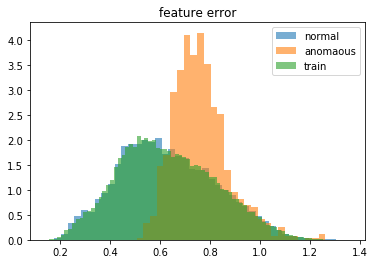

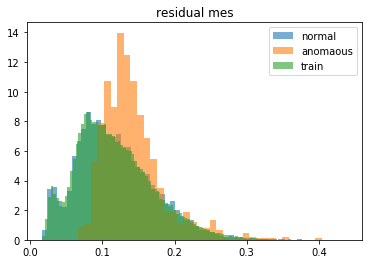

In [7]:

import scikitplot as skplt
import matplotlib.pyplot as plt


plt.hist(np.reshape(feature,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("feature error")

plt.hist(np.reshape(afeature,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_feature,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()    



plt.hist(np.reshape(res_mse,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("residual mes")



plt.hist(np.reshape(ares_mse,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_res_mse,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()    







0.722263146067


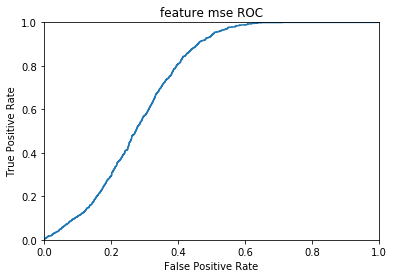

0.656932359551


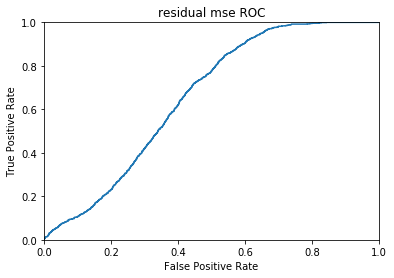

In [8]:

label_normal = np.zeros(np.array(feature).shape[0])
label_anomalous = np.ones(np.array(afeature).shape[0])

test = np.concatenate((label_normal, label_anomalous), axis=0)

pred = np.concatenate((np.reshape(feature,-1), np.reshape(afeature,-1)), axis=0)
#skplt.metrics.plot_roc_curve(label, data)
#plt.show()
                      
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
print( roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('feature mse ROC')
plt.show()
                      


label_normal = np.zeros(np.array(res_mse).shape[0])
label_anomalous = np.ones(np.array(ares_mse).shape[0])



test = np.concatenate((label_normal, label_anomalous), axis=0)

pred = np.concatenate((np.reshape(res_mse,-1), np.reshape(ares_mse,-1)), axis=0)
#skplt.metrics.plot_roc_curve(label, data)
#plt.show()
                      
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
print( roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('residual mse ROC')
plt.show()                      

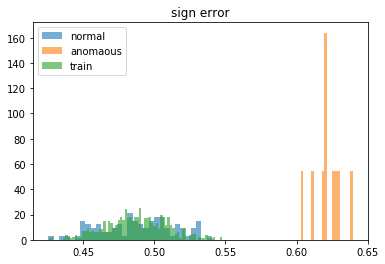

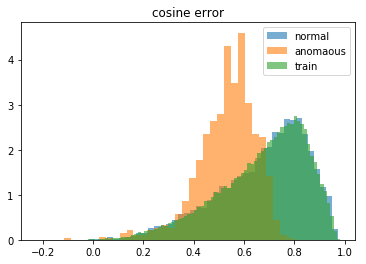

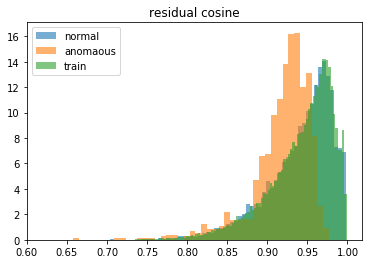

In [9]:
plt.hist(np.reshape(sign_error,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("sign error")

plt.hist(np.reshape(asign_error,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_sign_error,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()  







plt.hist(np.reshape(cosine,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("cosine error")

plt.hist(np.reshape(acosine,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_cosine,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()  


plt.hist(np.reshape(res_cos,-1), bins='auto', alpha=0.6, label="normal",normed=1)  # arguments are passed to np.histogram
plt.title("residual cosine")



plt.hist(np.reshape(ares_cos,-1), bins='auto', alpha=0.6, label="anomaous",normed=1)  # arguments are passed to np.histogram

plt.hist(np.reshape(train_res_cos,-1), bins='auto', alpha=0.6, label="train",normed=1)  # arguments are passed to np.histogram

plt.legend()
plt.show()    




1.0


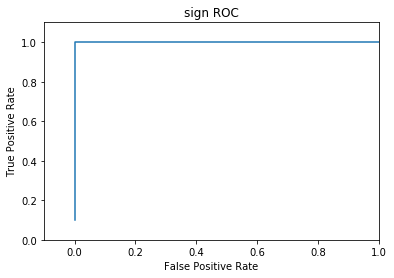

0.763159662921


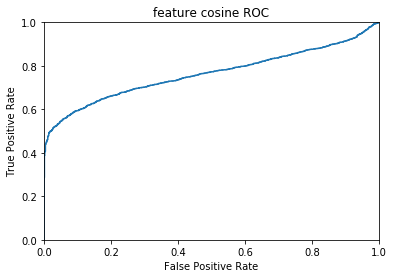

0.70651258427


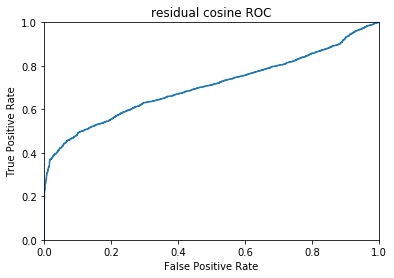

In [12]:
label_normal = np.zeros(np.array(sign_error).shape[0])
label_anomalous = np.ones(np.array(asign_error).shape[0])



test = np.concatenate((label_normal, label_anomalous), axis=0)

pred = np.concatenate((np.reshape(sign_error,-1), np.reshape(asign_error,-1)), axis=0)
#skplt.metrics.plot_roc_curve(label, data)
#plt.show()
                      
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
print( roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('sign ROC')
plt.show()    
                    
label_normal = np.ones(np.array(cosine).shape[0])
label_anomalous = np.zeros(np.array(acosine).shape[0])

test = np.concatenate((label_normal, label_anomalous), axis=0)

pred = np.concatenate((np.reshape(cosine,-1), np.reshape(acosine,-1)), axis=0)
#skplt.metrics.plot_roc_curve(label, data)
#plt.show()
                      
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
print( roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('feature cosine ROC')
plt.show()       



label_normal = np.ones(np.array(res_cos).shape[0])
label_anomalous = np.zeros(np.array(ares_cos).shape[0])

test = np.concatenate((label_normal, label_anomalous), axis=0)

pred = np.concatenate((np.reshape(res_cos,-1), np.reshape(ares_cos,-1)), axis=0)
#skplt.metrics.plot_roc_curve(label, data)
#plt.show()
                      
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
print( roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('residual cosine ROC')
plt.show()



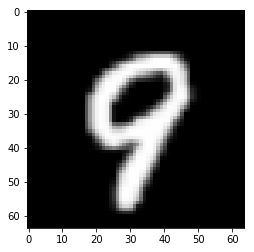

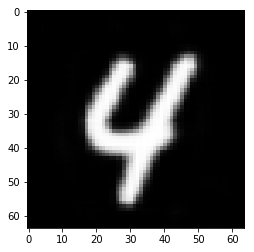

[[[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]]] [[  1.47834660e-08   3.37944880e-11   1.27801625e-09   4.94032926e-10
    1.35861200e-07   1.17537198e-08   3.85046349e-07   6.49159063e-07
    9.99998212e-01   5.86504939e-07]]
0.129499 0.733858 [[ 0.93563968]] [[ 0.55561626]]


In [13]:


im =  test_anomalous_data[111]      
plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')
plt.show()
im_enc= sess.run([D_enc],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})




im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})
Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : np.reshape(im_re,(1,64, 64,1)),z : im_z, c : im_c,isTrain : False})

plt.imshow(np.reshape(im_re,(64, 64)), cmap='Greys_r')
plt.show()

print(im_c,Q_c)

residual_e = np.mean(np.sqrt((np.reshape(im,(1,64*64))-np.reshape(im_re,(1,64*64)))**2))
residual_cosine = cosine_similarity(np.reshape(im,(1,64*64)),np.reshape(im_re,(1,64*64)))
feature_e = np.mean(np.sqrt((np.reshape(im_enc,(1,100))-np.reshape(im_re_enc,(1,100)))**2))
feature_cosine = cosine_similarity(np.reshape(im_enc,(1,100)),np.reshape(im_re_enc,(1,100)))

print(residual_e, feature_e, residual_cosine ,feature_cosine)

In [14]:
im_enc

[array([[[[-1.4594959 , -0.85019803, -1.74881029,  0.771882  ,  0.29230225,
           -0.06824562,  0.82174373, -1.26181304,  0.56704038,  0.81849712,
           -0.36406869, -1.09462273, -0.65284801,  1.16958046,  1.82655466,
            0.63757879, -0.85539865,  0.37215093,  1.17837453, -0.03712209,
           -0.8175168 , -0.2668637 , -1.7712394 ,  0.94711173, -0.83882731,
           -0.98073471,  0.60294461,  0.40419626, -0.35995656,  0.15152921,
            0.3780089 ,  0.68490285, -0.48703006, -0.67005736,  0.48580086,
            0.41813749,  0.20831877, -1.56027102, -0.2184325 , -1.11823392,
           -0.36248434,  1.16053712, -0.2622658 ,  1.98175251,  2.11877966,
           -0.43939906,  0.42846909,  1.7423625 , -0.82722545,  0.30388921,
            0.47557059, -0.37252933,  1.43442941, -2.29357243, -0.67671335,
            0.68069649,  1.01818717,  0.8854717 , -0.74788994, -0.9929536 ,
            1.56497109, -0.31611133,  0.8058362 ,  1.072245  ,  1.06502247,
            

In [15]:
im_re_enc

array([[[[ -5.55884004e-01,  -5.59493482e-01,  -4.57163036e-01,
            9.29829836e-01,  -7.46594608e-01,  -4.12902474e-01,
            2.35763416e-01,  -6.56059980e-01,  -1.73655272e-01,
           -1.94599152e-01,  -7.14095533e-01,  -1.18111682e+00,
           -3.59187245e-01,   5.13669431e-01,   3.13873053e-01,
            1.00078762e+00,  -1.36705554e+00,   6.16367757e-01,
            5.23988903e-01,   5.54244757e-01,  -9.71526355e-02,
           -5.91522753e-01,  -4.45361167e-01,  -4.91563052e-01,
           -9.44785833e-01,   6.50674224e-01,  -1.91142336e-01,
            4.00867373e-01,   1.18174577e+00,   1.46429777e+00,
           -1.87691942e-01,   1.38566434e+00,  -8.31381142e-01,
           -1.11317217e+00,  -4.14074659e-01,  -1.08244205e+00,
           -3.25987995e-01,  -2.21592951e+00,   5.70974350e-01,
            2.02091426e-01,   7.22491682e-01,   6.84783340e-01,
            3.96578461e-01,   8.45091283e-01,   1.88891780e+00,
            1.81076586e-01,  -2.22067833

In [16]:
np.mean(np.abs(np.sign(im_enc)-np.sign(im_re_enc)))

0.68000001

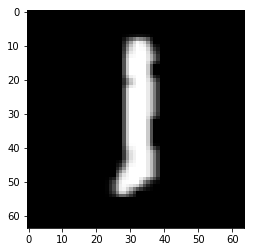

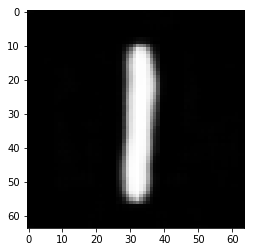

[[[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]]] [[  1.00000000e+00   1.41196166e-08   2.59527278e-11   4.43591032e-11
    5.78968731e-12   5.79979842e-09   7.14856939e-13   9.49999593e-11
    1.25652483e-11   3.63690653e-12]]
0.050166 0.505662 [[ 0.9835428]] [[ 0.78703427]]


In [17]:
im =  test_normal_data[11]      
plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')

plt.show()
im_enc= sess.run([D_enc],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})




im_re, im_z, im_c= sess.run([re_image, E_z, E_c],{u : np.reshape(im,(1,64, 64,1)),isTrain : False})
Q_c, im_re_enc= sess.run([Q_fake,D_enc],{u : np.reshape(im_re,(1,64, 64,1)),z : im_z, c : im_c,isTrain : False})

plt.imshow(np.reshape(im_re,(64, 64)), cmap='Greys_r')
plt.show()

print(im_c,Q_c)

residual_e = np.mean(np.sqrt((np.reshape(im,(1,64*64))-np.reshape(im_re,(1,64*64)))**2))
residual_cosine = cosine_similarity(np.reshape(im,(1,64*64)),np.reshape(im_re,(1,64*64)))
feature_e = np.mean(np.sqrt((np.reshape(im_enc,(1,100))-np.reshape(im_re_enc,(1,100)))**2))
feature_cosine = cosine_similarity(np.reshape(im_enc,(1,100)),np.reshape(im_re_enc,(1,100)))

print(residual_e, feature_e, residual_cosine ,feature_cosine)


In [21]:
im_enc

[array([[[[-0.07408322,  0.47310612,  1.42951274, -1.45061767, -0.80171084,
           -2.21274924,  0.04308845, -0.30874351,  0.02068696,  1.07540047,
            1.46520352,  0.21704032, -0.01678603,  0.57090348,  0.7354123 ,
           -0.8496325 ,  1.17189741, -0.45788938, -0.96938288,  0.77253735,
            1.49767113,  1.45548368, -0.61934239,  0.7871446 ,  0.76121181,
            0.31352854, -0.09268523, -0.66736734, -0.36368176, -1.3338697 ,
           -0.22651006, -0.30330881, -0.46811825,  0.28137162, -0.4694728 ,
            1.5027802 ,  0.62047535, -0.98429245,  0.59329283,  1.36412942,
            0.51711297,  1.12687683, -1.55153012,  1.06880093,  0.96429336,
           -2.00788331,  0.93369013, -0.88276631,  0.49261928,  0.2958796 ,
           -1.00092423, -0.87192494,  0.00532047,  0.28241599,  0.34157133,
            0.90100652,  0.22032675, -0.61770809, -0.05803668, -1.57409704,
           -0.36469319, -1.26195431, -0.76041102, -0.57900882, -1.39054835,
           -

In [22]:
im_re_enc

array([[[[-1.07497549, -0.51629293,  0.51791143, -1.56652677, -0.59023583,
          -1.48308492,  0.40985876,  0.5512979 , -0.33006862,  1.05506647,
           1.06139755,  1.33318079,  0.07588366,  0.32994452,  1.3314606 ,
          -1.01425505,  0.30085284, -0.0228003 , -1.21651244,  0.94582224,
           0.75638998,  0.96555173, -1.16178429,  0.36111706,  0.44377655,
          -0.14217062, -0.55035418, -1.0149014 , -1.03266776, -1.27845013,
           0.44029975, -0.81782085, -0.51978153, -0.01218626, -0.47479358,
           1.29546416,  0.65707111, -1.30640805,  0.38720331,  1.24421501,
           0.31016222,  1.09261262, -0.97273147,  1.91756809, -0.16618374,
          -0.96146667,  1.27820492, -0.50666589,  1.09033179,  0.62129653,
          -0.0373284 , -0.18289784,  0.51495111,  0.81988192, -0.01487288,
           1.33066106,  1.00803828,  0.08822443,  0.0640979 , -1.13682902,
           0.89695406, -1.16406119, -1.33705771, -0.35046452, -1.28588104,
           0.06828241,  1

In [23]:
np.mean(np.abs(np.sign(im_enc)-np.sign(im_re_enc)))

0.31999999